<a href="https://colab.research.google.com/github/RinHere/DATA_INTERN/blob/main/TEST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

print(uploaded.keys())


Saving products_backpacks_suitcases.csv to products_backpacks_suitcases.csv
Saving products_fashion_accessories.csv to products_fashion_accessories.csv
Saving products_men_bags.csv to products_men_bags.csv
Saving products_men_shoes.csv to products_men_shoes.csv
Saving products_women_bags.csv to products_women_bags.csv
Saving products_women_shoes.csv to products_women_shoes.csv
dict_keys(['products_backpacks_suitcases.csv', 'products_fashion_accessories.csv', 'products_men_bags.csv', 'products_men_shoes.csv', 'products_women_bags.csv', 'products_women_shoes.csv'])


In [ ]:

import os
import re
import pandas as pd
from datetime import datetime
from typing import List, Optional


DATA_DIR = "/content"


file_map = {
    "products_men_shoes.csv": "men_shoes",
    "products_women_shoes.csv": "women_shoes",
    "products_men_bags.csv": "men_bags",
    "products_women_bags.csv": "women_bags",
    "products_backpacks_suitcases.csv": "backpacks_suitcases",
    "products_fashion_accessories.csv": "fashion_accessories",
}


def to_snake_case(s: str) -> str:
    s = re.sub(r"[^\w]+", "_", s.strip())
    s = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", s)
    s = re.sub(r"_+", "_", s)
    return s.lower().strip("_")


def parse_price(value) -> Optional[float]:
    if pd.isna(value):
        return None
    if isinstance(value, (int, float)):
        return float(value)
    s = str(value).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return None

    s = re.sub(r"[^\d\,\.]", "", s)

    if "," in s and "." in s and s.rfind(",") > s.rfind("."):
        s = s.replace(".", "").replace(",", ".")
    else:

        s = s.replace(",", "")
    try:
        return float(s)
    except:
        return None


frames: List[pd.DataFrame] = []
missing_files = []
for fname, subcat in file_map.items():
    path = os.path.join(DATA_DIR, fname)
    if not os.path.exists(path):
        missing_files.append(fname)
        continue
    df = pd.read_csv(path)
    df.columns = [to_snake_case(c) for c in df.columns]
    df["sub_category"] = subcat
    frames.append(df)

if not frames:
    raise FileNotFoundError(
        f"Không tìm thấy tệp nào trong {DATA_DIR}. Thiếu: {missing_files}"
    )

merged = pd.concat(frames, ignore_index=True)


for col in merged.select_dtypes(include=["object"]).columns:
    merged[col] = merged[col].astype(str).str.strip()
    merged[col] = merged[col].replace({"": pd.NA, "nan": pd.NA, "None": pd.NA, "NONE": pd.NA})


price_cols_candidates = ["price", "sale_price", "current_price", "final_price", "special_price"]
orig_price_cols_candidates = ["original_price", "list_price", "regular_price", "old_price", "compare_at_price"]
brand_cols_candidates = ["brand", "brand_name", "manufacturer"]

def pick_first_col(candidates: list, df: pd.DataFrame) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

price_col = pick_first_col(price_cols_candidates, merged)
orig_price_col = pick_first_col(orig_price_cols_candidates, merged)
brand_col = pick_first_col(brand_cols_candidates, merged)


if price_col:
    merged[price_col] = merged[price_col].apply(parse_price)
if orig_price_col:
    merged[orig_price_col] = merged[orig_price_col].apply(parse_price)


def compute_discount_rate(row) -> Optional[float]:
    if price_col is None or orig_price_col is None:
        return None
    op = row.get(orig_price_col, None)
    p = row.get(price_col, None)
    if op is None or p is None or pd.isna(op) or pd.isna(p) or float(op) <= 0:
        return None
    try:
        return round((float(op) - float(p)) / float(op) * 100.0, 2)
    except:
        return None

merged["discount_rate"] = merged.apply(compute_discount_rate, axis=1)


UNBRANDED_TOKENS = {
    "no brand", "nobrand", "oem", "unbranded", "non brand", "non-brand",
    "generic", "khong thuong hieu", "không thương hiệu", "không nhãn hiệu",
    "none", "na", "null"
}

def compute_is_branded(val) -> Optional[bool]:
    if brand_col is None:
        return None
    if pd.isna(val):
        return False
    s = str(val).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s not in UNBRANDED_TOKENS and s != ""

if brand_col:
    merged["is_branded"] = merged[brand_col].apply(compute_is_branded)
else:
    merged["is_branded"] = None


summary = {
    "rows": len(merged),
    "cols": len(merged.columns),
    "price_col_detected": price_col,
    "orig_price_col_detected": orig_price_col,
    "brand_col_detected": brand_col,
    "missing_files": missing_files,
    "generated_at": datetime.now().isoformat(timespec="seconds"),
}
print("SUMMARY:", summary)


out_path = os.path.join(DATA_DIR, "merged_products_prepared.csv")
merged.to_csv(out_path, index=False)
print("Saved to:", out_path)


preview_cols = ["sub_category"]
if brand_col and brand_col not in preview_cols: preview_cols.append(brand_col)
if price_col and price_col not in preview_cols: preview_cols.append(price_col)
if orig_price_col and orig_price_col not in preview_cols: preview_cols.append(orig_price_col)
for c in ["discount_rate", "is_branded"]:
    if c in merged.columns and c not in preview_cols:
        preview_cols.append(c)


for c in ["id", "sku", "product_id", "title", "name"]:
    if c in merged.columns and c not in preview_cols:
        preview_cols.insert(0, c)
        break

display(merged[preview_cols].head(25))


SUMMARY: {'rows': 41603, 'cols': 22, 'price_col_detected': 'price', 'orig_price_col_detected': 'original_price', 'brand_col_detected': 'brand', 'missing_files': [], 'generated_at': '2025-09-26T03:25:32'}
Saved to: /content/merged_products_prepared.csv


,id,sub_category,brand,price,original_price,discount_rate,is_branded
0,103682599,men_shoes,OEM,9900.0,9900.0,0.0,False
1,176818958,men_shoes,OEM,10000.0,10000.0,0.0,False
2,119214657,men_shoes,OEM,9900.0,9900.0,0.0,False
3,164789853,men_shoes,OEM,24999.0,24999.0,0.0,False
4,208440729,men_shoes,OEM,14200.0,14200.0,0.0,False
5,254207022,men_shoes,OEM,8900.0,8900.0,0.0,False
6,146045291,men_shoes,OEM,24999.0,24999.0,0.0,False
7,98297802,men_shoes,OEM,25000.0,25000.0,0.0,False
8,95486564,men_shoes,OEM,26999.0,26999.0,0.0,False
9,192796419,men_shoes,OEM,25000.0,25000.0,0.0,False


== Tổng quantity_sold theo sub_category (giảm dần) ==


,sub_category,total_quantity_sold
0,fashion_accessories,253528.0
1,women_shoes,131200.0
2,backpacks_suitcases,113287.0
3,men_bags,105559.0
4,men_shoes,95201.0
5,women_bags,40494.0



 "Con gà đẻ trứng vàng": fashion_accessories với tổng quantity_sold = 253,528

== Giá bán trung bình & tỷ lệ giảm giá trung bình theo sub_category ==


,sub_category,avg_price,avg_discount_rate,n_products
2,men_bags,580201.698158,8.638307,4234
0,backpacks_suitcases,497216.379407,6.223492,5361
3,men_shoes,372459.547433,6.543709,5745
5,women_shoes,284161.841189,6.581037,5919
4,women_bags,247528.782890,5.031647,4325
1,fashion_accessories,82030.159810,4.578277,16019


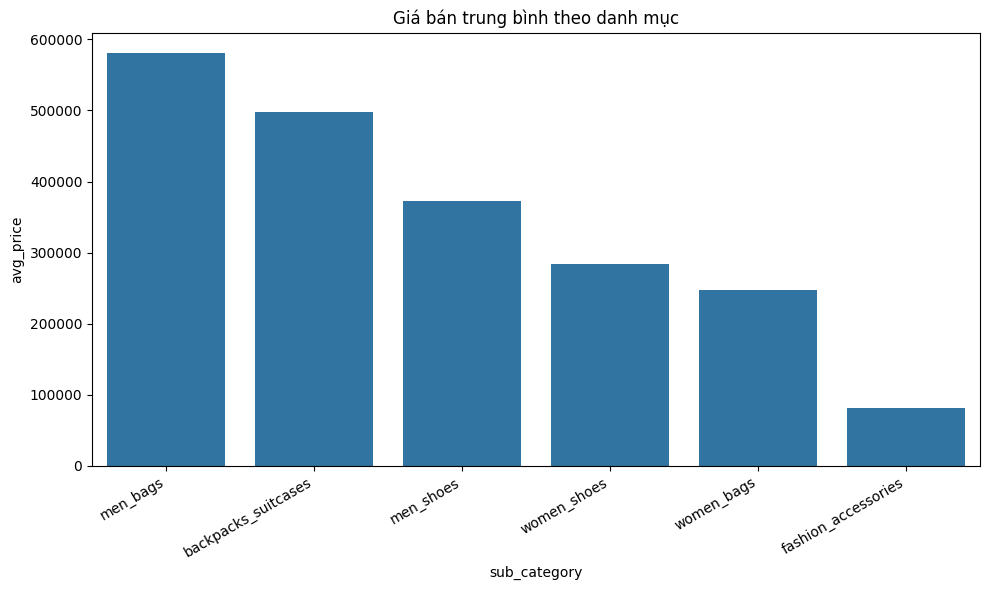

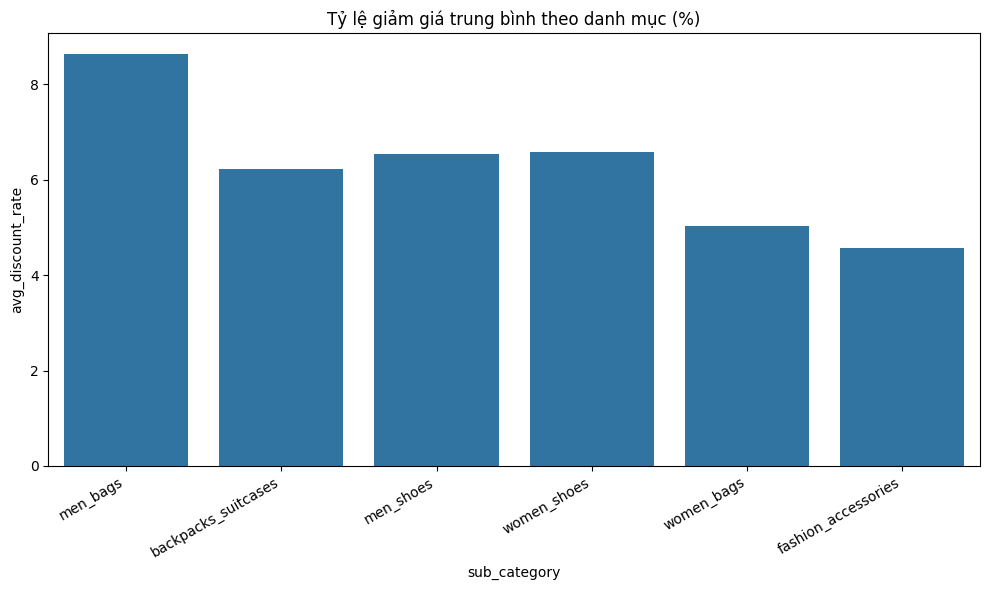

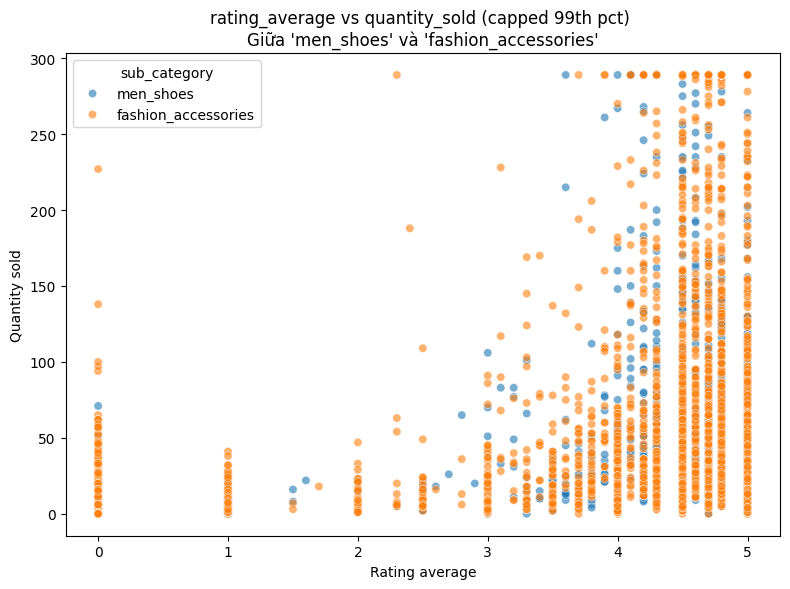


== Tương quan rating_average ~ quantity_sold (Pearson) cho 2 danh mục trọng tâm ==


/tmp/ipython-input-601475878.py:148: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["rating_average"].corr(g["quantity_sold_capped"]))


,sub_category,pearson_corr
0,fashion_accessories,0.435844
1,men_shoes,0.392012



== Ảnh hưởng has_video đến doanh số (mean quantity_sold) theo từng danh mục ==


has_video,no_video_avg_qty,video_avg_qty,lift_%
sub_category,,,
backpacks_suitcases,17.573809,48.387722,175.339987
fashion_accessories,13.471926,40.825961,203.044718
men_bags,25.621737,21.504225,-16.070383
men_shoes,15.069572,31.884990,111.585243
women_bags,7.382575,25.225000,241.682960
women_shoes,21.430709,29.038462,35.499305


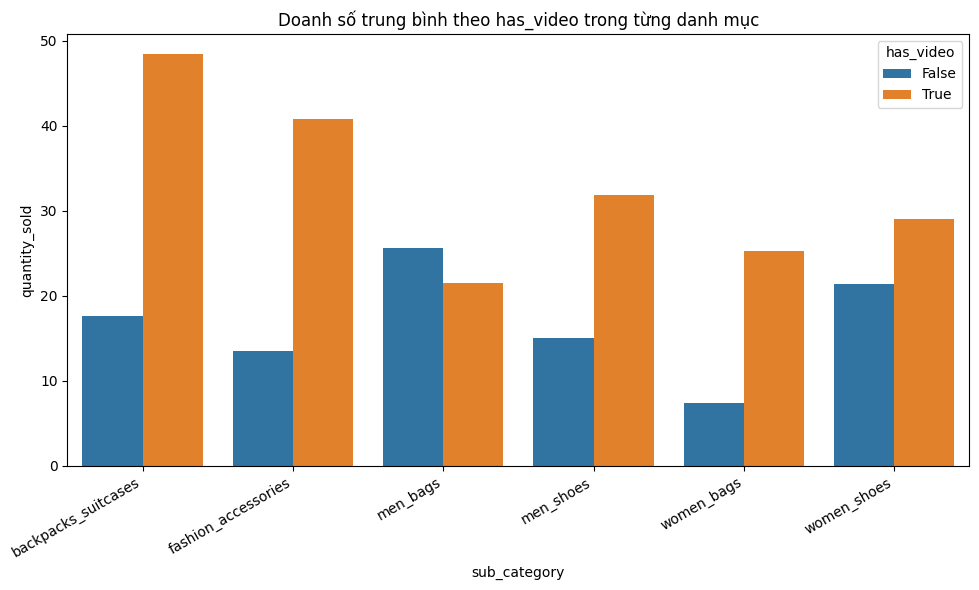


== Brand vs OEM theo từng danh mục (trung bình quantity_sold, lift %, p-value) ==


,sub_category,mean_qty_branded,mean_qty_oem,lift_%_branded_vs_oem,mannwhitneyu_pvalue,n_branded,n_oem
2,men_bags,60.192197,7.808070,670.897228,4.449896e-11,1384,2850
4,women_bags,26.521231,4.584984,478.436760,8.574560e-24,942,3383
3,men_shoes,35.943058,9.330942,285.202884,4.832204e-38,1563,4182
0,backpacks_suitcases,42.098028,11.193291,276.100534,5.345036e-83,1724,3637
1,fashion_accessories,33.427250,11.545751,189.519927,2.142371e-41,3134,12885
5,women_shoes,35.931940,16.732799,114.739565,4.126624e-17,1675,4244


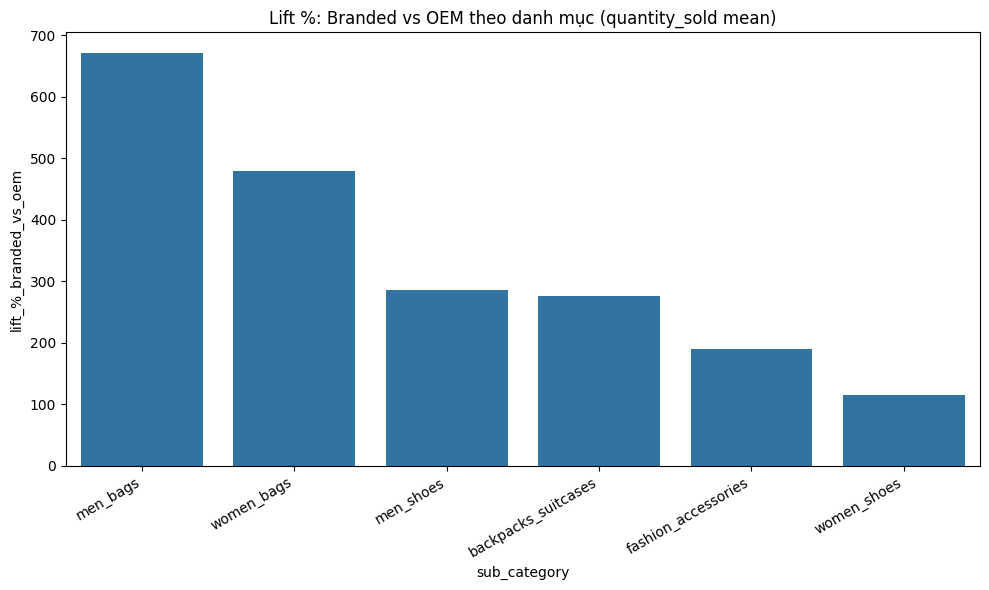


 Đã lưu tất cả bảng/kết quả vào: /content/outputs
   - overview_total_quantity_by_sub_category.csv
   - overview_price_discount_by_sub_category.csv
   - corr_rating_vs_quantity_menShoes_vs_fashionAccessories.csv
   - video_impact_by_sub_category.csv
   - brand_vs_oem_by_sub_category.csv
   - và các file .png biểu đồ tương ứng


In [ ]:

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


DATA_DIR = "/content"
INPUT_FILE = os.path.join(DATA_DIR, "merged_products_prepared.csv")
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)


if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(
        f"Không tìm thấy {INPUT_FILE}. Hãy chạy Phần 1 để tạo merged_products_prepared.csv."
    )

df = pd.read_csv(INPUT_FILE)


needed_cols = [
    "sub_category", "quantity_sold", "price", "discount_rate",
    "rating_average", "has_video", "is_branded"
]
for c in needed_cols:
    if c not in df.columns:
        df[c] = np.nan


def to_float_safe(x):
    try:
        return float(x)
    except:
        return np.nan

df["quantity_sold"] = df["quantity_sold"].apply(to_float_safe)
df["price"] = df["price"].apply(to_float_safe)
df["discount_rate"] = df["discount_rate"].apply(to_float_safe)
df["rating_average"] = df["rating_average"].apply(to_float_safe)


def to_bool_safe(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s in {"1","true","yes","y","t","có","co","video","have","has","x","✓"}

df["has_video"] = df["has_video"].apply(to_bool_safe)


def to_bool_or_nan(x):
    if isinstance(x, bool): return x
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in {"true","1","yes"}: return True
    if s in {"false","0","no"}: return False
    return np.nan

df["is_branded"] = df["is_branded"].apply(to_bool_or_nan)


df_plot = df.copy()
q_hi = df_plot["quantity_sold"].quantile(0.99) if df_plot["quantity_sold"].notna().any() else np.nan
if not np.isnan(q_hi) and q_hi > 0:
    df_plot["quantity_sold_capped"] = np.where(df_plot["quantity_sold"] > q_hi, q_hi, df_plot["quantity_sold"])
else:
    df_plot["quantity_sold_capped"] = df_plot["quantity_sold"]


golden = (
    df.groupby("sub_category", dropna=False)["quantity_sold"]
      .sum(min_count=1)
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={"quantity_sold":"total_quantity_sold"})
)
print("== Tổng quantity_sold theo sub_category (giảm dần) ==")
display(golden)
golden.to_csv(os.path.join(OUT_DIR, "overview_total_quantity_by_sub_category.csv"), index=False)

if len(golden) > 0 and not pd.isna(golden.loc[0, "total_quantity_sold"]):
    print(f'\n "Con gà đẻ trứng vàng": {golden.loc[0,"sub_category"]} '
          f'với tổng quantity_sold = {int(golden.loc[0,"total_quantity_sold"]):,}')


price_disc = (
    df.groupby("sub_category", dropna=False)
      .agg(
          avg_price=("price","mean"),
          avg_discount_rate=("discount_rate","mean"),
          n_products=("price","count")
      )
      .reset_index()
      .sort_values("avg_price", ascending=False)
)
print("\n== Giá bán trung bình & tỷ lệ giảm giá trung bình theo sub_category ==")
display(price_disc)
price_disc.to_csv(os.path.join(OUT_DIR, "overview_price_discount_by_sub_category.csv"), index=False)


plt.figure(figsize=(10,6))
ax = sns.barplot(data=price_disc, x="sub_category", y="avg_price")
plt.title("Giá bán trung bình theo danh mục")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_price_by_sub_category.png"), dpi=150)
plt.show()

plt.figure(figsize=(10,6))
ax = sns.barplot(data=price_disc, x="sub_category", y="avg_discount_rate")
plt.title("Tỷ lệ giảm giá trung bình theo danh mục (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_discount_rate_by_sub_category.png"), dpi=150)
plt.show()


focus_cats = ["men_shoes", "fashion_accessories"]
mask = (
    df_plot["sub_category"].isin(focus_cats)
    & df_plot["rating_average"].notna()
    & df_plot["quantity_sold_capped"].notna()
)
df_scatter = df_plot.loc[mask, ["sub_category","rating_average","quantity_sold_capped"]].copy()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_scatter,
    x="rating_average",
    y="quantity_sold_capped",
    hue="sub_category",
    alpha=0.6
)
plt.title("rating_average vs quantity_sold (capped 99th pct) \nGiữa 'men_shoes' và 'fashion_accessories'")
plt.xlabel("Rating average")
plt.ylabel("Quantity sold")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "scatter_rating_vs_quantity_menShoes_vs_fashionAccessories.png"), dpi=150)
plt.show()


corrs = (
    df_scatter.groupby("sub_category")
              .apply(lambda g: g["rating_average"].corr(g["quantity_sold_capped"]))
              .reset_index(name="pearson_corr")
)
print("\n== Tương quan rating_average ~ quantity_sold (Pearson) cho 2 danh mục trọng tâm ==")
display(corrs)
corrs.to_csv(os.path.join(OUT_DIR, "corr_rating_vs_quantity_menShoes_vs_fashionAccessories.csv"), index=False)


video_agg = (
    df.groupby(["sub_category","has_video"], dropna=False)["quantity_sold"]
      .mean()
      .reset_index()
      .pivot(index="sub_category", columns="has_video", values="quantity_sold")
      .rename(columns={False:"no_video_avg_qty", True:"video_avg_qty"})
)
video_agg["lift_%"] = ((video_agg["video_avg_qty"] - video_agg["no_video_avg_qty"]) / video_agg["no_video_avg_qty"] * 100
                       ).replace([np.inf, -np.inf], np.nan)
print("\n== Ảnh hưởng has_video đến doanh số (mean quantity_sold) theo từng danh mục ==")
display(video_agg)
video_agg.to_csv(os.path.join(OUT_DIR, "video_impact_by_sub_category.csv"))


video_plot = (
    df.groupby(["sub_category","has_video"], dropna=False)["quantity_sold"]
      .mean()
      .reset_index()
)
plt.figure(figsize=(10,6))
sns.barplot(data=video_plot, x="sub_category", y="quantity_sold", hue="has_video")
plt.title("Doanh số trung bình theo has_video trong từng danh mục")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "bar_video_impact_by_sub_category.png"), dpi=150)
plt.show()


brand_stats = []
subcats = df["sub_category"].dropna().unique().tolist()

for sc in sorted(subcats):
    sub_df = df[df["sub_category"] == sc]
    b = sub_df[sub_df["is_branded"] == True]["quantity_sold"].dropna()
    o = sub_df[sub_df["is_branded"] == False]["quantity_sold"].dropna()

    mean_b = b.mean() if len(b) else np.nan
    mean_o = o.mean() if len(o) else np.nan
    lift = ((mean_b - mean_o) / mean_o * 100) if (not np.isnan(mean_b) and not np.isnan(mean_o) and mean_o != 0) else np.nan


    pval = np.nan
    try:
        if len(b) >= 10 and len(o) >= 10:
            _, pval = stats.mannwhitneyu(b, o, alternative="two-sided")
    except Exception as e:
        pval = np.nan

    brand_stats.append({
        "sub_category": sc,
        "mean_qty_branded": mean_b,
        "mean_qty_oem": mean_o,
        "lift_%_branded_vs_oem": lift,
        "mannwhitneyu_pvalue": pval,
        "n_branded": len(b),
        "n_oem": len(o),
    })

brand_df = pd.DataFrame(brand_stats).sort_values("lift_%_branded_vs_oem", ascending=False)
print("\n== Brand vs OEM theo từng danh mục (trung bình quantity_sold, lift %, p-value) ==")
display(brand_df)
brand_df.to_csv(os.path.join(OUT_DIR, "brand_vs_oem_by_sub_category.csv"), index=False)

plt.figure(figsize=(10,6))
sns.barplot(data=brand_df, x="sub_category", y="lift_%_branded_vs_oem")
plt.title("Lift %: Branded vs OEM theo danh mục (quantity_sold mean)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "bar_lift_branded_vs_oem.png"), dpi=150)
plt.show()

print(f"\n Đã lưu tất cả bảng/kết quả vào: {OUT_DIR}")
print("   - overview_total_quantity_by_sub_category.csv")
print("   - overview_price_discount_by_sub_category.csv")
print("   - corr_rating_vs_quantity_menShoes_vs_fashionAccessories.csv")
print("   - video_impact_by_sub_category.csv")
print("   - brand_vs_oem_by_sub_category.csv")
print("   - và các file .png biểu đồ tương ứng")


In [ ]:

import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

DATA_DIR  = "/content"
INPUT_FP  = os.path.join(DATA_DIR, "merged_products_prepared.csv")
OUT_DIR   = "/content/outputs"; os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(INPUT_FP)

TARGET = "quantity_sold"
num_cols = [c for c in ["price","original_price","discount_rate","rating_average","number_of_images","number_of_reviews"] if c in df.columns]
cat_cols = [c for c in ["sub_category","fulfillment_type","has_video","is_branded"] if c in df.columns]

def to_float(x):
    try: return float(x)
    except: return np.nan

df[TARGET] = df[TARGET].apply(to_float)
for c in num_cols: df[c] = df[c].apply(to_float)


p99 = df[TARGET].quantile(0.99)
df[TARGET] = np.where(df[TARGET] > p99, p99, df[TARGET])

mask = df[TARGET].notna()
if "price" in num_cols: mask &= df["price"].notna()
if "rating_average" in num_cols: mask &= df["rating_average"].notna()
data = df.loc[mask, list(set(num_cols + cat_cols + [TARGET]))].copy()


MAX_ROWS = 25000
if len(data) > MAX_ROWS:
    data = data.sample(MAX_ROWS, random_state=42)

y_raw = data[TARGET].astype(float)
X = data.drop(columns=[TARGET])

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.02)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", ohe)])

preprocess = ColumnTransformer([("num", num_pipe, num_cols),
                                ("cat", cat_pipe, cat_cols)])

target_transform = Pipeline([
    ("log", FunctionTransformer(func=np.log1p, inverse_func=np.expm1, check_inverse=True)),
    ("z", StandardScaler()),
])

rf = RandomForestRegressor(
    n_estimators=400, max_depth=16, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)

model = Pipeline([("prep", preprocess), ("rf", rf)])

ttr = TransformedTargetRegressor(regressor=model, transformer=target_transform)

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)

ttr.fit(X_train, y_train_raw)



y_pred_orig = ttr.predict(X_test)
rmse_orig = mean_squared_error(y_test_raw, y_pred_orig) ** 0.5
r2_orig   = r2_score(y_test_raw, y_pred_orig)

y_pred_trans = ttr.regressor_.predict(X_test)
y_test_trans = ttr.transformer_.transform(y_test_raw.values.reshape(-1,1)).ravel()
rmse_trans = mean_squared_error(y_test_trans, y_pred_trans) ** 0.5
r2_trans   = r2_score(y_test_trans, y_pred_trans)

print("\n=== FAST RF (log1p + z-score) ===")
print(f"RMSE : {rmse_trans:.4f}")
print(f"R²   : {r2_trans:.4f}")



=== FAST RF (log1p + z-score) ===
RMSE : 0.5422
R²   : 0.7094


In [ ]:
!pip install -U xgboost

In [ ]:

import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


try:
    import xgboost as xgb
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    import xgboost as xgb
from xgboost.callback import EarlyStopping
from xgboost import DMatrix


DATA_DIR  = "/content"
INPUT_FP  = os.path.join(DATA_DIR, "merged_products_prepared.csv")

df = pd.read_csv(INPUT_FP)
TARGET = "quantity_sold"


num_cols = [c for c in ["price","original_price","discount_rate","rating_average","number_of_images","number_of_reviews"] if c in df.columns]
cat_cols = [c for c in ["sub_category","fulfillment_type","has_video","is_branded"] if c in df.columns]

def to_float(x):
    try: return float(x)
    except: return np.nan

df[TARGET] = df[TARGET].apply(to_float)
for c in num_cols: df[c] = df[c].apply(to_float)


p99 = df[TARGET].quantile(0.99)
df[TARGET] = np.where(df[TARGET] > p99, p99, df[TARGET])

mask = df[TARGET].notna()
if "price" in num_cols: mask &= df["price"].notna()
if "rating_average" in num_cols: mask &= df["rating_average"].notna()
data = df.loc[mask, list(set(num_cols + cat_cols + [TARGET]))].copy()


MAX_ROWS = 25000
if len(data) > MAX_ROWS:
    data = data.sample(MAX_ROWS, random_state=42)

y_raw = data[TARGET].astype(float).values
X = data.drop(columns=[TARGET])


num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])


try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.02)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])


y_transform = Pipeline([
    ("log", FunctionTransformer(func=np.log1p, inverse_func=np.expm1, check_inverse=True)),
    ("z", StandardScaler()),
])

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)


y_train_trans = y_transform.fit_transform(y_train_raw.reshape(-1,1)).ravel()
y_test_trans  = y_transform.transform(y_test_raw.reshape(-1,1)).ravel()


X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)


dtrain = DMatrix(X_train_processed, label=y_train_trans)
dtest = DMatrix(X_test_processed, label=y_test_trans)


params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.06,
    "max_depth": 8,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist"
}


early_stopping = EarlyStopping(
    rounds=30,
    metric_name="rmse",
    data_name="validation_0",

)


evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtest, "validation_0")],
    callbacks=[early_stopping],
    evals_result=evals_result
)


y_pred_trans = model.predict(dtest)
rmse_trans = mean_squared_error(y_test_trans, y_pred_trans) ** 0.5
r2_trans   = r2_score(y_test_trans, y_pred_trans)


y_pred_orig = y_transform.inverse_transform(y_pred_trans.reshape(-1,1)).ravel()
rmse_orig = mean_squared_error(y_test_raw, y_pred_orig) ** 0.5
r2_orig   = r2_score(y_test_raw, y_pred_orig)

print("\n=== FAST XGBoost (log1p + z-score, Native API) ===")
print(f"RMSE : {rmse_trans:.4f}")
print(f"R²   : {r2_trans:.4f}")

[0]	validation_0-rmse:0.96393
[1]	validation_0-rmse:0.92518
[2]	validation_0-rmse:0.88942
[3]	validation_0-rmse:0.88001
[4]	validation_0-rmse:0.84776
[5]	validation_0-rmse:0.83984
[6]	validation_0-rmse:0.81064
[7]	validation_0-rmse:0.78423
[8]	validation_0-rmse:0.75967
[9]	validation_0-rmse:0.73759
[10]	validation_0-rmse:0.71768
[11]	validation_0-rmse:0.69938
[12]	validation_0-rmse:0.68272
[13]	validation_0-rmse:0.66780
[14]	validation_0-rmse:0.65415
[15]	validation_0-rmse:0.64211
[16]	validation_0-rmse:0.63103
[17]	validation_0-rmse:0.62818
[18]	validation_0-rmse:0.61837
[19]	validation_0-rmse:0.60970
[20]	validation_0-rmse:0.60168
[21]	validation_0-rmse:0.59444
[22]	validation_0-rmse:0.58795
[23]	validation_0-rmse:0.58611
[24]	validation_0-rmse:0.58084
[25]	validation_0-rmse:0.57565
[26]	validation_0-rmse:0.57123
[27]	validation_0-rmse:0.56738
[28]	validation_0-rmse:0.56355
[29]	validation_0-rmse:0.56045
[30]	validation_0-rmse:0.55771
[31]	validation_0-rmse:0.55528
[32]	validation_0-